In [3]:
#Setup
import collections
import pandas as pd
import numpy as np
import spacy
import pickle
from spacy.tokens import DocBin
from spacy.tokens import Doc
nlp = spacy.load('en_core_web_md')

import matplotlib.pyplot as plt
import squarify
import seaborn as sns
plt.rcParams["figure.figsize"] = [20,10]

#Set sentiment extensions
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sent_analyzer = SentimentIntensityAnalyzer()
def sentiment_scores(docx):
    return sent_analyzer.polarity_scores(docx.text)
Doc.set_extension("sentimenter",getter=sentiment_scores)

In [4]:
#A help function to read the pickle file
def read_data(path):
    tweets = pickle.load(open(path, 'rb'))
    doc_bin = DocBin().from_bytes(tweets)
    docs = list(doc_bin.get_docs(nlp.vocab))
    return docs
tweets = read_data('tweets_new.p')

In [51]:
#A help function to count the elements within a given feature
def count_feature(x):
    c = collections.Counter([item.text for tweet in x for item in tweet])
    return c.most_common()

#A help funtion to print the relevant frequency of the feature
def pl(x):
    counts = count_feature(x)
    size = [count[1] for count in counts]
    label = [count[0] for count in counts]
    squarify.plot(sizes=size[:50], label=label[:50], alpha=.5)

In [48]:
#Vector Feature : sentence vector
vecs = [tweet.vector for tweet in tweets]

In [63]:
#Vector Feature : word vector
vecs_word = [[word.vector for word in tweet] for tweet in tweets]

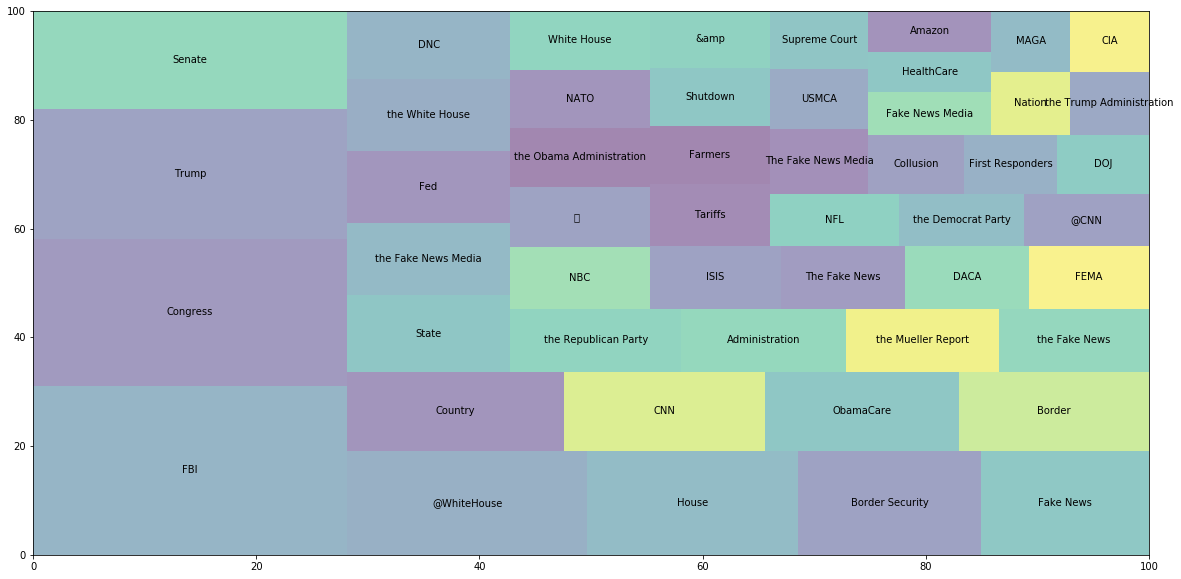

In [52]:
#Entity Feature: organizations
ORG = [[ent for ent in tweet.ents if ent.label_ == 'ORG'] for tweet in tweets]
#pl(ORG)

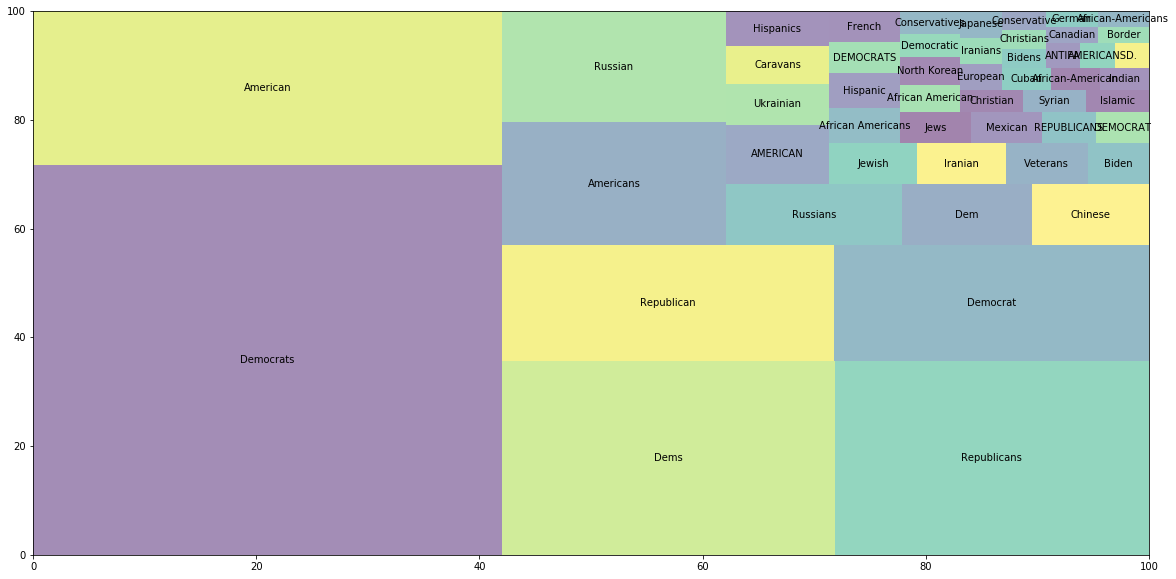

In [53]:
#Entity Feature: nationalities or religious or political groups
NORP = [[ent for ent in tweet.ents if ent.label_ == 'NORP'] for tweet in tweets]
#pl(NORP)

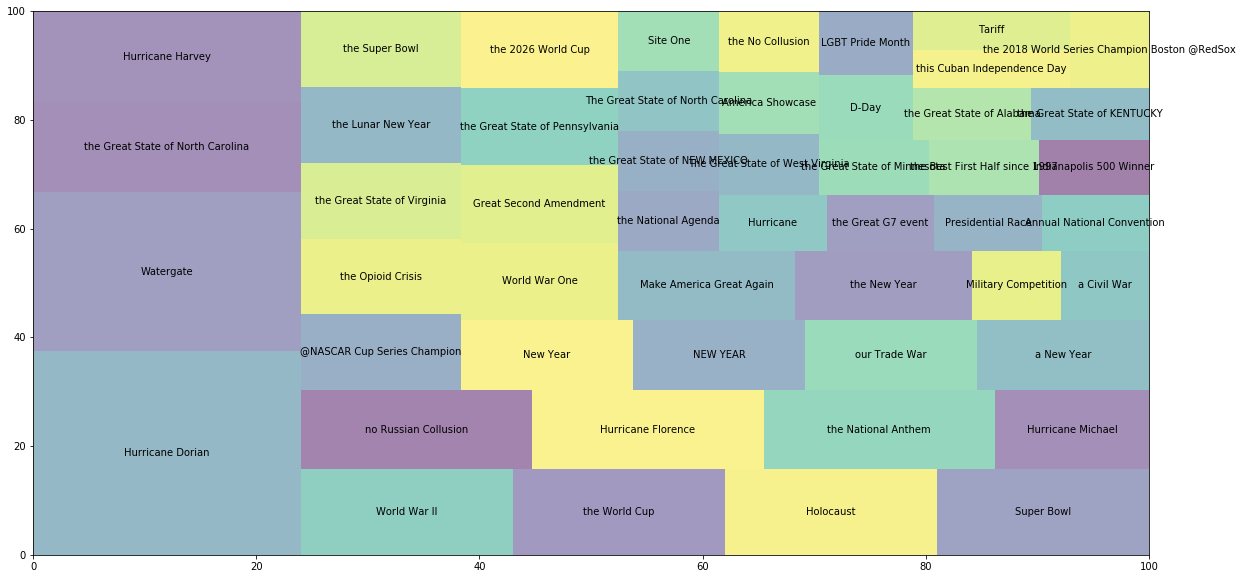

In [54]:
#Entity Feature: events
EVENT = [[ent for ent in tweet.ents if ent.label_ == 'EVENT'] for tweet in tweets]
#pl(EVENT)

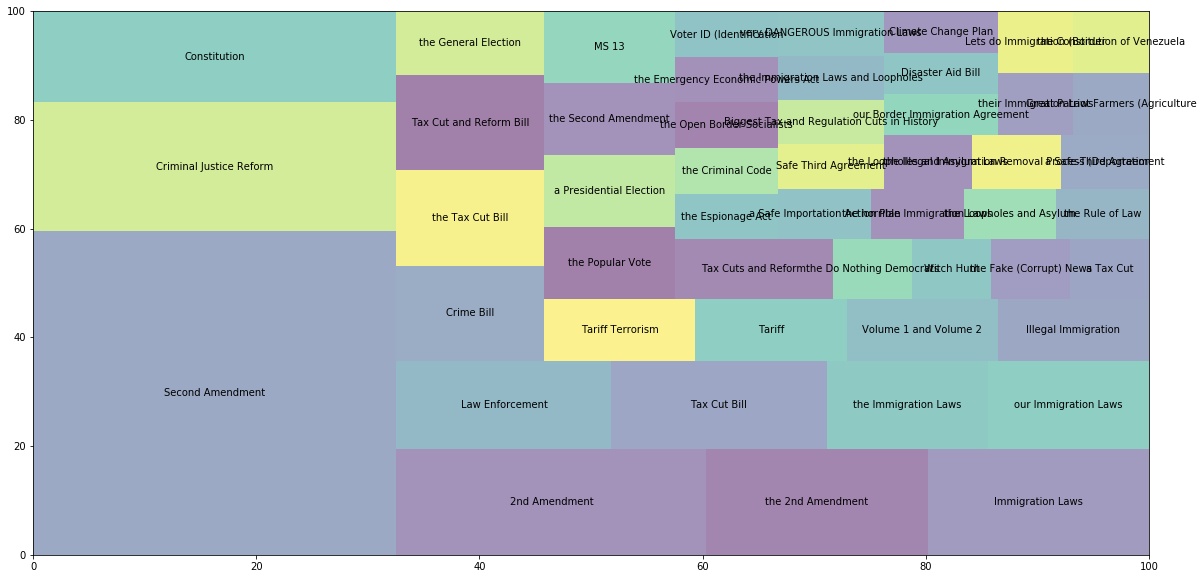

In [55]:
#Entity Feature: laws
LAW = [[ent for ent in tweet.ents if ent.label_ == 'LAW'] for tweet in tweets]
#pl(LAW)

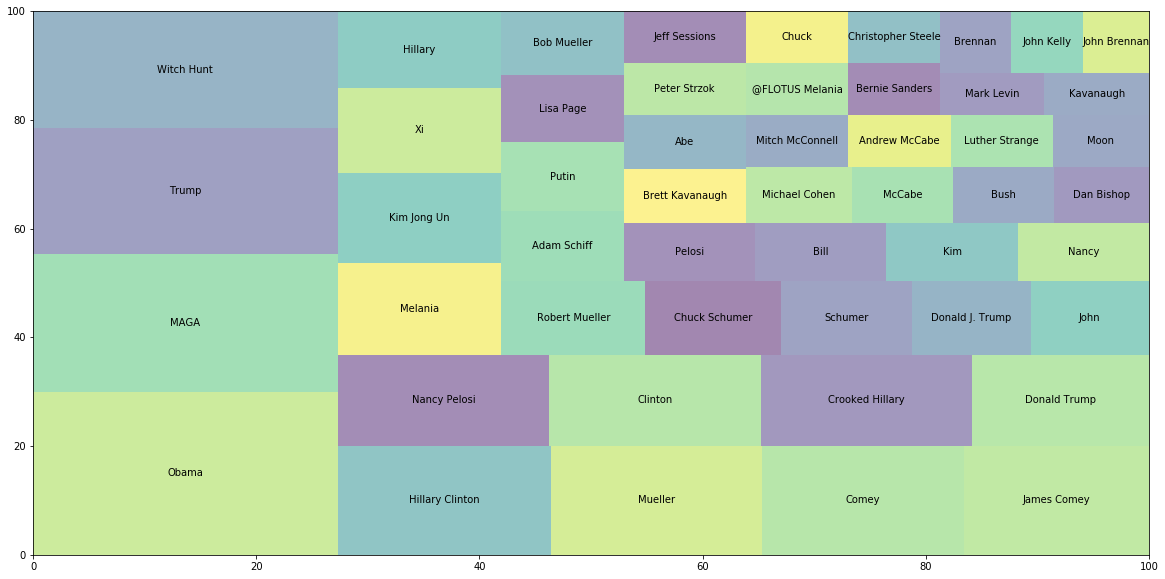

In [56]:
#Entity Feature: persons
PERSON = [[ent for ent in tweet.ents if ent.label_ == 'PERSON'] for tweet in tweets]
#pl(PERSON)

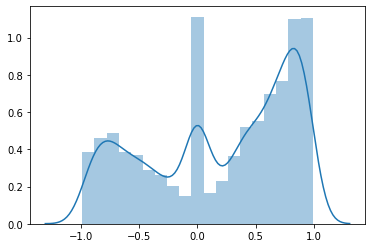

In [23]:
#Scalar Feature: sentiment
Sen = [tweet._.sentimenter for tweet in tweets]
Sen_compound = [s['compound'] for s in Sen]
#sns.distplot(Sen_compound)

# A quick model that works

In [196]:
date = pd.read_excel('tweets_new.xls', usecols=[0], parse_dates=[0])
sp = pd.read_excel('S&P 500_new.xls', parse_dates=[0])
date['created_at'] = date['created_at'].dt.date
sp.iloc[:, 0] = sp.iloc[:, 0].dt.date

In [197]:
dft = pd.DataFrame({'date': date['created_at'],
                    'sentiment': Sen_compound,
                    'org': [len(o) for o in ORG],
                    'person': [len(o) for o in PERSON],
                    'law': [len(o) for o in LAW],
                    'event': [len(o) for o in EVENT],
                    'norp': [len(o) for o in NORP]})
dft = pd.DataFrame(dft.groupby('date').mean())
sp = pd.DataFrame(sp.groupby('Unnamed: 0')['Close'].last())

In [198]:
df = dft.merge(sp, how='left', left_index=True, right_index=True)

In [199]:
y = (df['Close'].shift(-1) > df['Close']) * 1
X = dft

In [203]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
clf = RandomForestClassifier(20)
cross_validate(clf, X, y, scoring='accuracy', cv=5, return_train_score=True)

{'fit_time': array([0.02899575, 0.02797318, 0.02597427, 0.0279839 , 0.02698445]),
 'score_time': array([0.00299716, 0.00400805, 0.00299811, 0.00199842, 0.00299788]),
 'test_score': array([0.59090909, 0.63451777, 0.66326531, 0.63265306, 0.64285714]),
 'train_score': array([0.9910828 , 0.99363868, 0.99110546, 0.98983482, 0.99110546])}

In [205]:
X

,sentiment,org,person,law,event,norp
date,,,,,,
2017-01-02,0.009686,0.142857,0.000000,0.000000,0.142857,0.000000
2017-01-03,0.093930,1.200000,0.200000,0.100000,0.000000,0.200000
2017-01-04,-0.217740,0.600000,0.500000,0.000000,0.000000,0.500000
2017-01-05,-0.142250,0.833333,0.333333,0.000000,0.000000,0.333333
2017-01-06,0.364708,0.666667,0.583333,0.000000,0.000000,0.083333
...,...,...,...,...,...,...
2019-09-27,-0.205741,0.727273,0.590909,0.000000,0.000000,0.136364
2019-09-28,0.155692,0.692308,0.384615,0.000000,0.000000,0.153846
2019-09-29,-0.014600,0.437500,0.500000,0.000000,0.000000,0.312500
